https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter


In [2]:
import numpy as np
import scipy.linalg as la
des = [7/8, 3/8]
n = len(des)
s = np.diag(des)
q, _ = la.qr(np.random.rand(n, n))
A = q.T @ s @ q
eigs_h, vecs_h = np.linalg.eig(A)
print(eigs_h)
U = la.expm(1j*A)
eigs_u, vecs_u = np.linalg.eig(U)
print(eigs_u)

[0.875 0.375]
[0.64099686+0.7675435j  0.93050762+0.36627253j]


In [3]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[1], n_of_qubs)

In [4]:
for qubit in range(n_of_qubs):
    qpe.h(qubit)

In [5]:
# def get_gate(A, n):    
#     pauli_op = PauliSumOp(SparsePauliOp.from_operator(A))
#     phi = Parameter('ϕ')
#     evolution_op = (phi * pauli_op).exp_i() # exp(-iϕA)
#     trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op).bind_parameters({phi: np.pi/n})
#     #----control---------
#     gate = trotterized_op.to_circuit()
#     gate.name = f"e^(i*A*pi/{n})"
#     gate.label = f"e^(i*A*np.pi/{n})"
#     gate = gate.to_gate().control()
#     #---------------------
#     return gate

In [6]:
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
gate = UnitaryGate(U).control(1)
repetitions = 1
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe.append(gate,[i, n_of_qubs])
    repetitions *= 2

In [7]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [7]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n_of_qubs)
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)

In [8]:
qpe.draw()

┌───┐                                                        »
 q_0: ────────────┤ H ├─────────────────■──────────────────────────────────────»
                  ├───┤                 │                                      »
 q_1: ────────────┤ H ├─────────────────┼──────────■──────────■────────────────»
                  ├───┤                 │          │          │                »
 q_2: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────■─────»
                  ├───┤                 │          │          │          │     »
 q_3: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_4: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_5: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_6: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_7: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_8: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
                  ├───┤                 │          │          │          │     »
 q_9: ────────────┤ H ├─────────────────┼──────────┼──────────┼──────────┼─────»
      ┌───────────┴───┴───────────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_10: ┤ Initialize(-0.6344,0.773) ├┤ Unitary ├┤ Unitary ├┤ Unitary ├┤ Unitary ├»
      └───────────────────────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 10/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                        »
« q_0: ──────────────────────────────────────────────────────────────────»
«                                                                        »
« q_1: ──────────────────────────────────────────────────────────────────»
«                                                                        »
« q_2: ─────■──────────■──────────■──────────────────────────────────────»
«           │          │          │                                      »
« q_3: ─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
«           │          │          │          │          │          │     »
« q_4: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«           │          │          │          │          │          │     »
« q_5: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«           │          │          │          │          │          │     »
« q_6: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«           │          │          │          │          │          │     »
« q_7: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«           │          │          │          │          │          │     »
« q_8: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«           │          │          │          │          │          │     »
« q_9: ─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
«      ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
«q_10: ┤ Unitary ├┤ Unitary ├┤ Unitary ├┤ Unitary ├┤ Unitary ├┤ Unitary ├»
«      └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 10/══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                        »
« q_0: ────────────────────────────────────

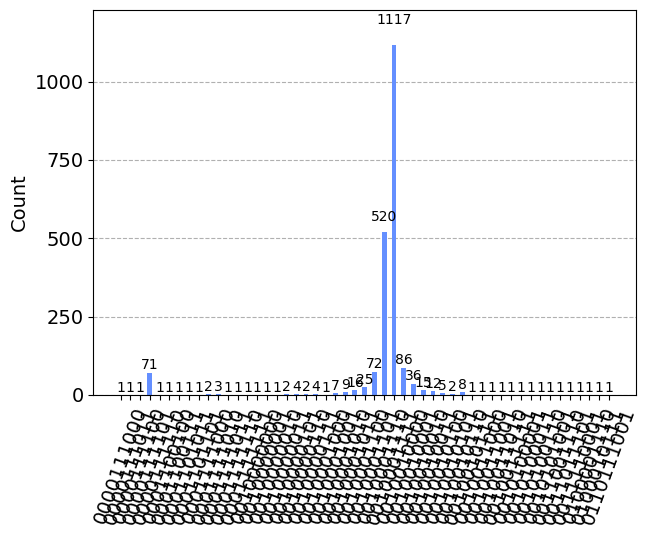

In [24]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

In [25]:
print(answer)

[(62, 1), (206, 1), (221, 1), (103, 1), (153, 1), (152, 1), (241, 1), (130, 1), (59, 1), (279, 1), (169, 1), (154, 1), (56, 1), (166, 1), (161, 1), (107, 1), (151, 1), (441, 1), (126, 1), (60, 1), (270, 1), (129, 1), (136, 1), (123, 1), (163, 1), (109, 1), (128, 1), (159, 1), (127, 1), (100, 1), (131, 2), (120, 2), (134, 2), (149, 2), (122, 3), (133, 4), (135, 4), (148, 5), (137, 7), (150, 8), (138, 9), (147, 12), (146, 15), (139, 16), (140, 25), (145, 36), (61, 71), (141, 72), (144, 86), (142, 520), (143, 1117)]


In [26]:
import scipy.linalg as la
print(la.expm(1j*4*np.pi*143/shots))

[[0.63912444+0.76910334j]]


In [14]:
eigs_u

array([0.93050762+0.36627253j, 0.64099686+0.7675435j ])

In [16]:
# eigs_h

In [17]:
# 4*np.pi*61/shots